# ACP Y CLUSTERING
## Dataset: Penguins
### Nombre: Sebastian Calderon

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial import distance
from scipy.spatial.distance import squareform
import scipy.cluster.hierarchy as sch

from FuncionesMineria2 import (plot_varianza_explicada, plot_cos2_heatmap, plot_corr_cos, plot_cos2_bars,
                               plot_contribuciones_proporcionales, plot_pca_scatter, plot_pca_scatter_with_vectors,
                               plot_pca_scatter_with_categories)

### Introducción

El presente trabajo tiene como objetivo explorar el conjunto de datos penguins, disponible en la librería seaborn de Python, y aplicar técnicas de reducción de dimensionalidad, específicamente el Análisis de Componentes Principales (ACP), así como métodos de agrupamiento (clustering).

El conjunto de datos penguins contiene información sobre tres especies de pingüinos: Adelie, Chinstrap y Gentoo, registradas en tres islas distintas: Biscoe, Dream y Torgersen. Cada registro incluye mediciones clave como la longitud y profundidad del pico (en milímetros), la longitud de la aleta (en milímetros), la masa corporal (en gramos) y el género del pingüino, el cual puede ser Male (macho), Female (hembra) o NaN en caso de datos faltantes.

El análisis de estos datos permitirá identificar patrones en las características morfológicas de los pingüinos, reducir la dimensionalidad para facilitar su interpretación y aplicar técnicas de agrupamiento para examinar posibles segmentaciones dentro del conjunto de datos.

### Exploración de los Datos.

In [2]:
# Carga del dataset penguins desde Seaborn

penguins = sns.load_dataset('penguins')
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [3]:
# Creación de un Dataframe solo con las variables continuas

penguins_continuas = penguins.select_dtypes(include=['float64', 'int64'])
print(penguins_continuas.head())

   bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0            39.1           18.7              181.0       3750.0
1            39.5           17.4              186.0       3800.0
2            40.3           18.0              195.0       3250.0
3             NaN            NaN                NaN          NaN
4            36.7           19.3              193.0       3450.0


In [4]:
# Lista con los nombres de las variables continuas

variables=penguins_continuas.columns.tolist()
variables

['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

### Estadísticos descriptivos

In [5]:
estadisticos = pd.DataFrame({
    'Mínimo': penguins[variables].min(),
    'Q1': penguins[variables].quantile(0.25),
    'Mediana': penguins[variables].median(),
    'Q3': penguins[variables].quantile(0.75),
    'Media': penguins[variables].mean(),
    'Máximo': penguins[variables].max(),
    'Desv. típica': penguins[variables].std(),
    'Varianza': penguins[variables].var(),
    'Coef. de Variación': (penguins[variables].std() / penguins[variables].mean()),
    'Missing': penguins[variables].isna().sum()
})

estadisticos_2 = estadisticos.round(decimals = 2)
display(estadisticos_2)

,Mínimo,Q1,Mediana,Q3,Media,Máximo,Desv. típica,Varianza,Coef. de Variación,Missing
bill_length_mm,32.1,39.22,44.45,48.5,43.92,59.6,5.46,29.81,0.12,2
bill_depth_mm,13.1,15.60,17.30,18.7,17.15,21.5,1.97,3.90,0.12,2
flipper_length_mm,172.0,190.00,197.00,213.0,200.92,231.0,14.06,197.73,0.07,2
body_mass_g,2700.0,3550.00,4050.00,4750.0,4201.75,6300.0,801.95,643131.08,0.19,2


In [6]:
# Eliminación de Missing necesaria para el aplicar las tecnicas

penguins_continuas = penguins_continuas.dropna()
penguins_continuas.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


### Visualización de los Datos

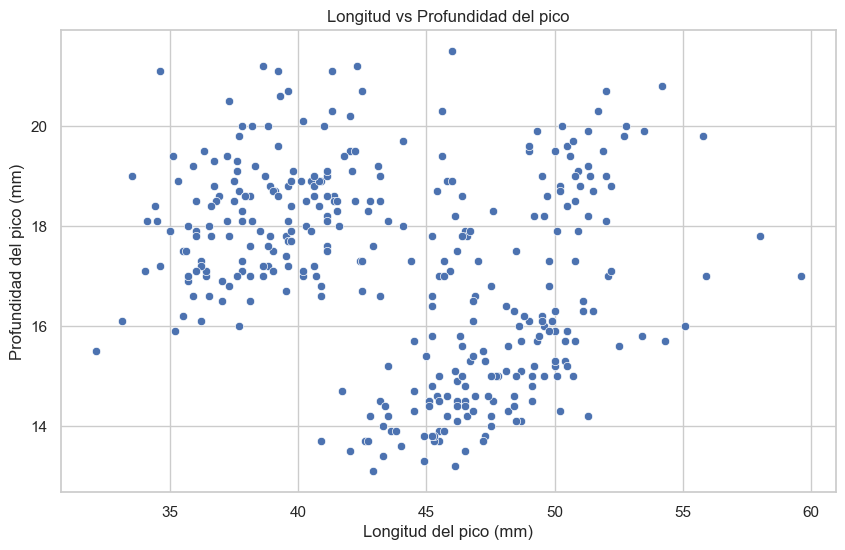

In [7]:
# Grafico de dispersión para ver Longitud y Profundidad del Pico

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=penguins, x="bill_length_mm", y="bill_depth_mm")
plt.title("Longitud vs Profundidad del pico")
plt.xlabel("Longitud del pico (mm)")
plt.ylabel("Profundidad del pico (mm)")
plt.show()

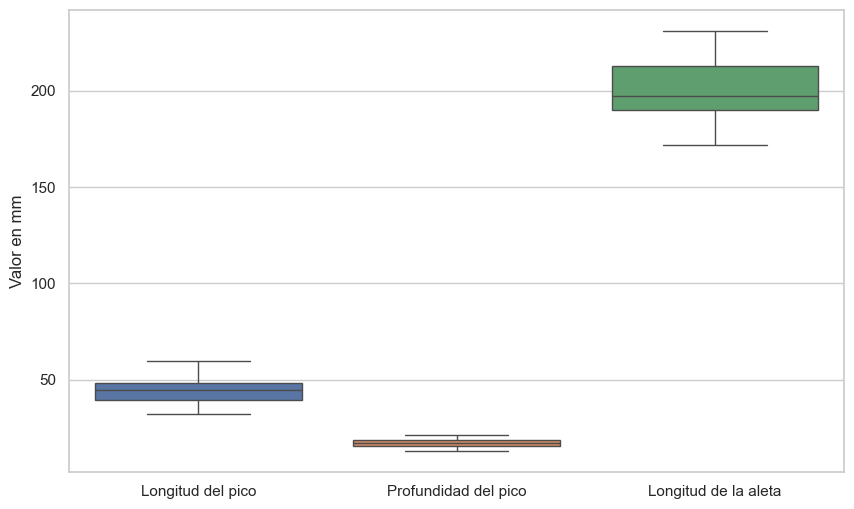

In [8]:
# Box Plot para analizar como se comportan los datos de las variables, Longitud del Pico, Profundidad del Pico y Longitud de la Aleta.

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data=penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']])
plt.ylabel("Valor en mm")
plt.xticks([0, 1, 2], ['Longitud del pico', 'Profundidad del pico', 'Longitud de la aleta'])
plt.show()

En el gráfico de dispersión, podemos observar a simple vista la formación de dos grandes grupos al analizar las características del pico. Además, el boxplot muestra que la profundidad del pico presenta poca variabilidad, mientras que la longitud de la aleta exhibe una mayor dispersión.

## 1. Matriz de Correlaciones

                   bill_length_mm  bill_depth_mm  flipper_length_mm  \
bill_length_mm           1.000000      -0.235053           0.656181   
bill_depth_mm           -0.235053       1.000000          -0.583851   
flipper_length_mm        0.656181      -0.583851           1.000000   
body_mass_g              0.595110      -0.471916           0.871202   

                   body_mass_g  
bill_length_mm        0.595110  
bill_depth_mm        -0.471916  
flipper_length_mm     0.871202  
body_mass_g           1.000000  


<Axes: >

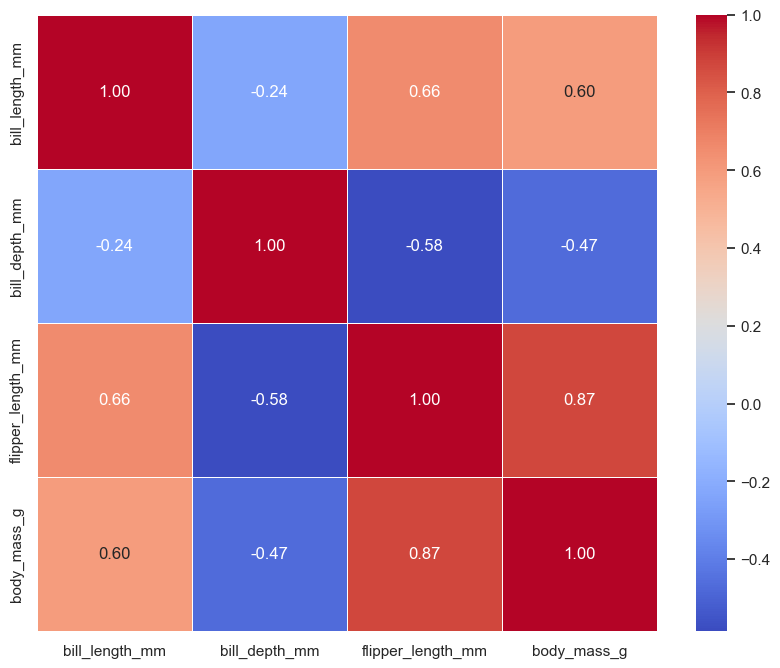

In [9]:
# Cálculo y representación de la matriz de correlación entre las variables que representan las caracteristicas fisicas del pinguino. 

R = penguins_continuas.corr()
print(R)
plt.figure(figsize=(10, 8))
sns.heatmap(R, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

Las correlaciones más altas se presentan entre la longitud de la aleta y la masa corporal, con un valor de 0.87. También se observa una correlación de 0.66 entre la longitud del pico y la longitud de la aleta, y de 0.60 entre la longitud del pico y la masa corporal.

## 2. Analisis PCA

In [10]:
# Estandarización los datos:

penguins_std = pd.DataFrame(
    StandardScaler().fit_transform(penguins_continuas),  
    columns=['{}_z'.format(variable) for variable in variables], 
    index=penguins_continuas.index 
)
penguins_std.head()

,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z
0,-0.884499,0.785449,-1.418347,-0.564142
1,-0.811126,0.126188,-1.062250,-0.501703
2,-0.664380,0.430462,-0.421277,-1.188532
4,-1.324737,1.089724,-0.563715,-0.938776
5,-0.847812,1.748985,-0.777373,-0.689020


In [11]:
# Instancia de análisis de Componentes Principales con 4 componentes, obtención de autovalores y varianza acumulada

pca = PCA(n_components=4)
fit = pca.fit(penguins_std)

autovalores = fit.explained_variance_
autovalores

var_explicada = fit.explained_variance_ratio_
var_explicada_2 = np.sum(var_explicada[:2])
var_explicada_2

var_acumulada = np.cumsum(var_explicada)
var_acumulada

data = {'Autovalores': autovalores, 'Variabilidad Explicada': var_explicada, 'Variabilidad Acumulada': var_acumulada}
tabla = pd.DataFrame(data, index=['Componente {}'.format(i) for i in range(1, fit.n_components_+1)])

print(tabla)

              Autovalores  Variabilidad Explicada  Variabilidad Acumulada
Componente 1     2.761831                0.688439                0.688439
Componente 2     0.774782                0.193129                0.881568
Componente 3     0.366307                0.091309                0.972877
Componente 4     0.108810                0.027123                1.000000


Según los autovalores, la primera componente es la más importante, con un valor de 2.76. La segunda componente también mantiene una relevancia considerable, con un autovalor de 0.77. A partir de esta, las dos últimas componentes tienen valores muy pequeños, lo que indica una menor contribución a la variabilidad de los datos.

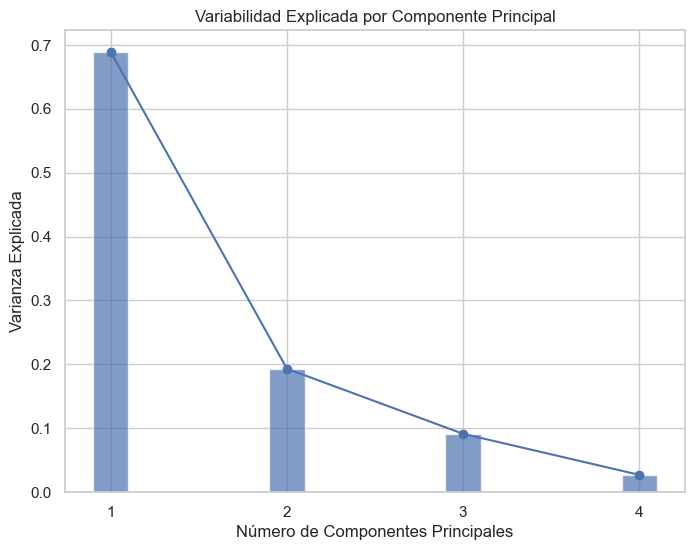

In [12]:
# Representacion de la variabilidad explicada

plot_varianza_explicada(var_explicada, fit.n_components_)

Si consideramos las dos primeras componentes, podemos explicar casi el 90% de la variabilidad. Por ello, seleccionaremos estas como nuestro número total de componentes.

In [13]:
# Instancia ACP con las dos primeras componentes y autovectores.

pca = PCA(n_components=2)
fit = pca.fit(penguins_std)

print(pca.components_)

autovectores = pd.DataFrame(pca.components_.T,
                            columns = ['Autovector {}'.format(i) for i in range(1, fit.n_components_+1)],
                            index = ['{}_z'.format(variable) for variable in variables])

display(autovectores)

[[ 0.45525033 -0.40033468  0.57601332  0.54835019]
 [ 0.59703114  0.79776657  0.0022822   0.08436292]]


,Autovector 1,Autovector 2
bill_length_mm_z,0.455250,0.597031
bill_depth_mm_z,-0.400335,0.797767
flipper_length_mm_z,0.576013,0.002282
body_mass_g_z,0.548350,0.084363


In [14]:
# Calculo las dos primeras componentes principales en dataframe de datos estandarizados

resultados_pca = pd.DataFrame(fit.transform(penguins_std),
                              columns=['Componente {}'.format(i) for i in range(1, fit.n_components_+1)],
                              index=penguins_std.index)

penguins_z_cp = pd.concat([penguins_std, resultados_pca], axis=1)
display(penguins_z_cp)

,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z,Componente 1,Componente 2
0,-0.884499,0.785449,-1.418347,-0.564142,-1.843445,0.047702
1,-0.811126,0.126188,-1.062250,-0.501703,-1.306762,-0.428348
2,-0.664380,0.430462,-0.421277,-1.188532,-1.369181,-0.154476
4,-1.324737,1.089724,-0.563715,-0.938776,-1.878827,-0.002048
5,-0.847812,1.748985,-0.777373,-0.689020,-1.911748,0.829210
...,...,...,...,...,...,...
338,0.601305,-1.750171,0.931890,0.903175,2.006436,-0.958909
340,0.527932,-1.445897,1.003109,0.809516,1.840886,-0.767714
341,1.188289,-0.735923,1.501644,1.933419,2.760742,0.288886
342,0.234440,-1.192335,0.789451,1.246590,1.722364,-0.704269


## 3. Analisis PCA con 2 Componentes

In [15]:
# Analisis de componentes principales sobre la matriz de correlaciones

variables_cp = penguins_z_cp.columns

correlacion = pd.DataFrame(np.corrcoef(penguins_std.T, resultados_pca.T),
                           index = variables_cp, columns = variables_cp)

n_variables = fit.n_features_in_
correlaciones_penguins_con_cp = correlacion.iloc[:fit.n_features_in_, fit.n_features_in_:]
display(correlaciones_penguins_con_cp)

,Componente 1,Componente 2
bill_length_mm_z,0.755463,0.524748
bill_depth_mm_z,-0.664333,0.701180
flipper_length_mm_z,0.955862,0.002006
body_mass_g_z,0.909957,0.074149


In [16]:
# Calculo del Cos2 de las componentes

cos2 = correlaciones_penguins_con_cp**2
display(cos2)

,Componente 1,Componente 2
bill_length_mm_z,0.570724,0.275361
bill_depth_mm_z,0.441338,0.491654
flipper_length_mm_z,0.913672,0.000004
body_mass_g_z,0.828021,0.005498


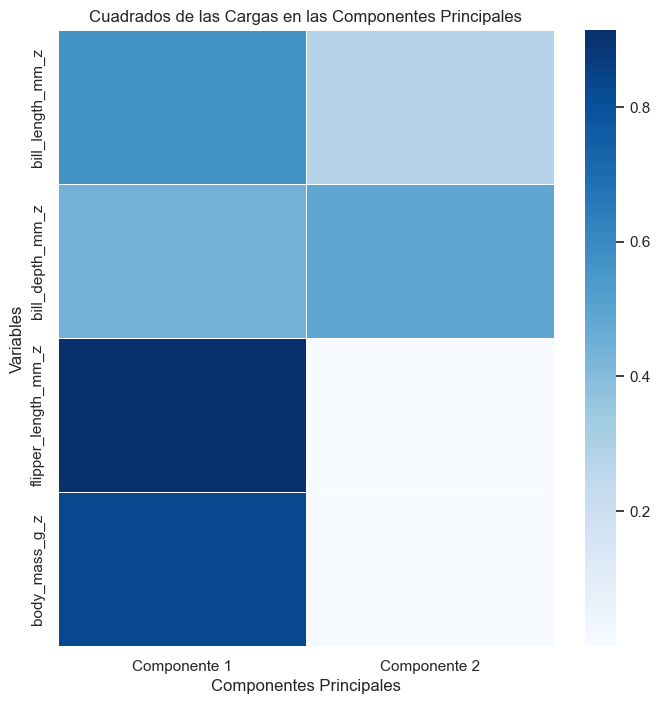

In [17]:
# Grafica del Cos2 de las componentes junto con las caracteristicas

plot_cos2_heatmap(cos2)

En el mapa de calor, observamos que dos variables se ubican claramente en la primera componente: la masa corporal y la longitud de la aleta. En cuanto a la longitud del pico, aunque en la segunda componente el color no es completamente blanco, sigue siendo notablemente más claro que en la primera. Finalmente, en la profundidad del pico, la diferencia de color entre ambas componentes no es tan marcada, lo que indica que ambas explican esta variable de manera similar. No obstante, todas las variables están bien representadas en el análisis.

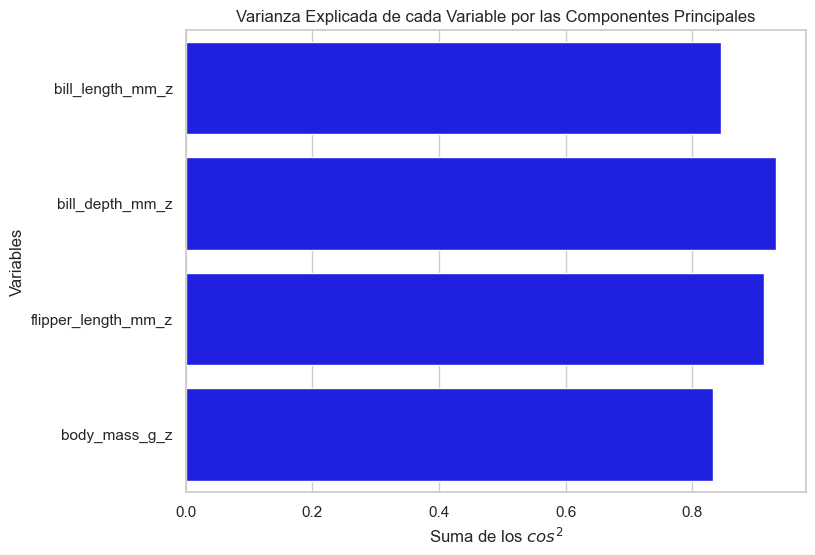

In [18]:
#Grafica de barras del Cos2

plot_cos2_bars(cos2)

Podemos ver claramente que las dos componentes explican las cuatro variables con más del 80% de la variabilidad, lo que indica que utilizar solo dos componentes es una elección adecuada.

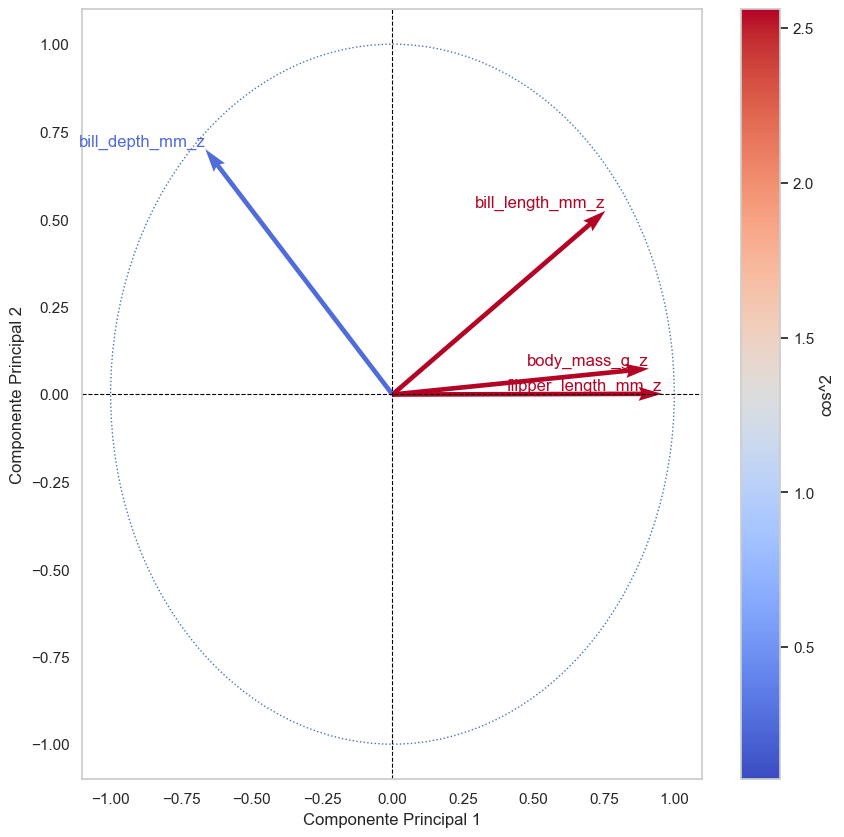

In [19]:
# Heatmap de los vectores en las componentes principales

plot_corr_cos(fit.n_components, correlaciones_penguins_con_cp)

### a. Representación de los Componentes

La longitud del pico, la masa corporal y la longitud de la aleta están alineadas, lo que indica que estas variables están correlacionadas y contribuyen fuertemente a la variabilidad en la primera componente principal (PC1). Por otro lado, la profundidad del pico se encuentra en una dirección ortogonal a las demás, lo que sugiere que su variabilidad no está alineada con las otras variables y que contribuye más a la segunda componente principal (PC2).

La primera componente principal (PC1) captura principalmente la variabilidad en el tamaño corporal y la longitud del pico/aletas, mientras que la segunda componente principal (PC2) captura la variabilidad en la profundidad del pico. Esto sugiere que existen dos dimensiones principales en las características físicas de los pingüinos: el tamaño general y la forma del pico.

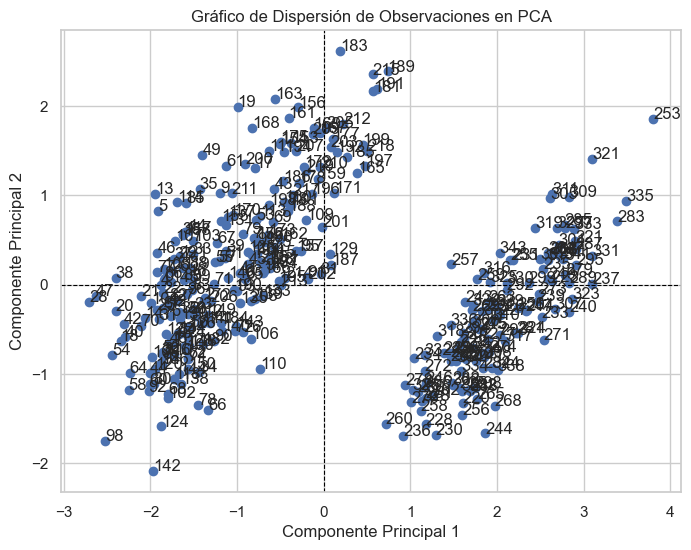

In [20]:
#Grafico de dispersión de observaciones en el analisis de componentes principales

plot_pca_scatter(pca, penguins_std, fit.n_components)

### b. Relevancia en cada Componente

Al analizar el gráfico, podemos observar claramente dos grupos de pingüinos bien definidos. El primer grupo, ubicado a la izquierda, está principalmente representado por la segunda componente, ya que la mayoría de los individuos se sitúan por encima de cero en esta componente. En cuanto al segundo grupo, ubicado a la derecha, parece ser explicado principalmente por la primera componente, pues la mayoría de los valores se encuentran en la parte positiva de esta componente.

### c. Indice de Valoración de Caracteristicas Fisicas del Pinguino

Para construir un índice que valore de forma conjunta las características físicas de un pingüino, utilizando una combinación lineal de todas las variables, emplearía los valores de Cos² para asignar los pesos correspondientes. Luego, sumaría los valores de ambas componentes para cada variable, es decir:


Variable -	            Suma cos² (Componente 1 + Componente 2)

bill_length_mm_z -      0.846085

bill_depth_mm_z -       0.932992

flipper_length_mm_z	-   0.913676

body_mass_g_z -         0.833519

Luego, normalizaría el índice para que el resultado fuera 1, y de esta forma, mi índice quedaría de la siguiente manera para determinar el índice de cada especie.

I = 0.240 (bill_length_mm_z)+ 0.265 (bill_depth_mm_z)+ 0.259 (flipper_length_mm_z)+ 0.236 (body_mass_g_z)

## 4. Agrupamiento Jerarquico

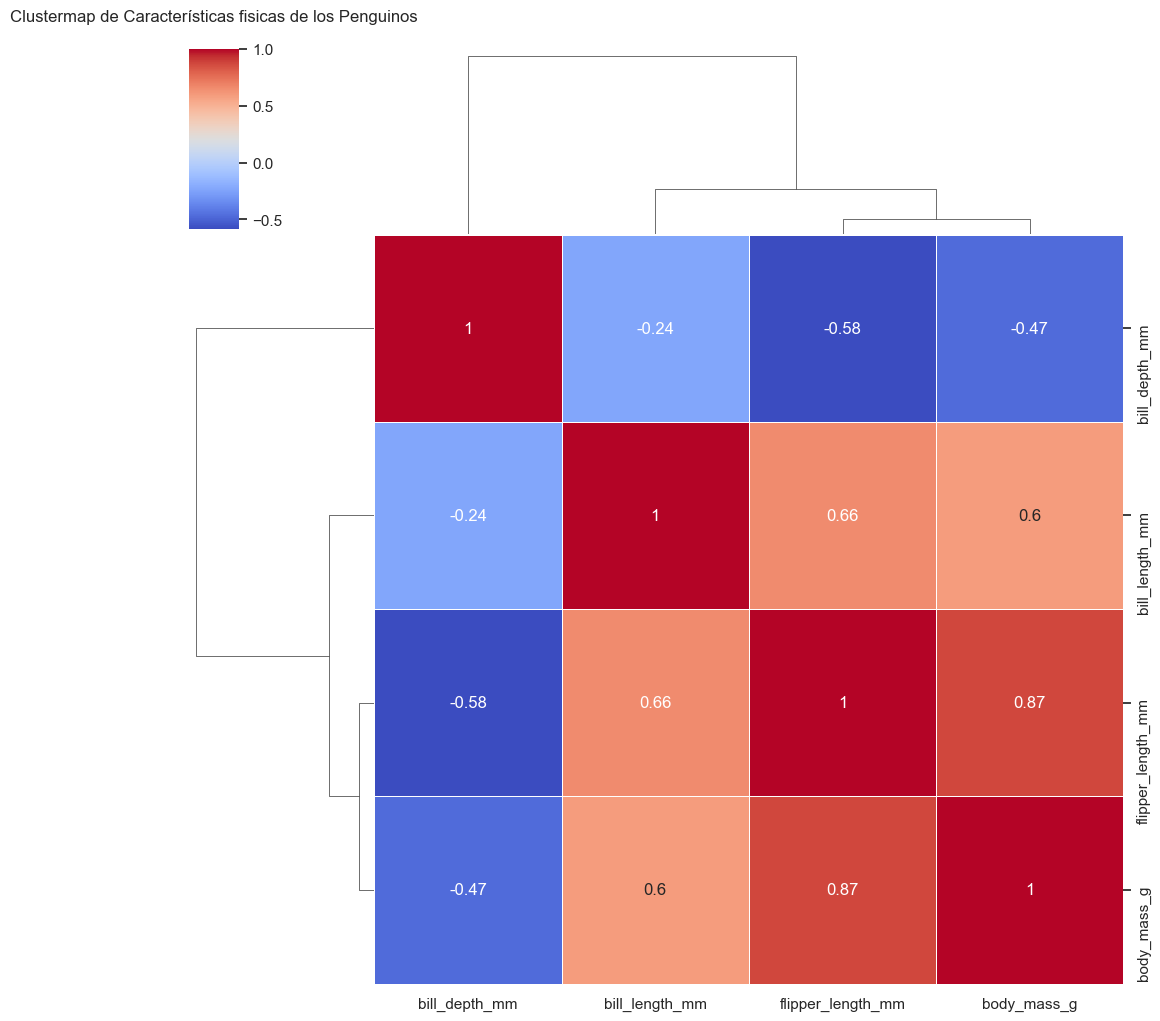

In [21]:
# Clustermap para visualizar la relación entre las variables continuas de penguins

sns.clustermap(penguins_continuas.corr(), cmap='coolwarm', annot=True, linewidths=0.5)
plt.title('Clustermap de Características fisicas de los Penguinos', pad=20)
plt.show()

In [22]:
# Calculo de las distancias euclidianas por pares

distance_matrix = distance.cdist(penguins_continuas, penguins_continuas, 'euclidean')
print("Matriz de Distancia:")
distance_small = distance_matrix[:5, :5]
distance_small = pd.DataFrame(distance_small, index=penguins_continuas.index[:5], columns=penguins_continuas.index[:5])
distance_small_rounded = distance_small.round(2)
print(distance_small_rounded)

Matriz de Distancia:
        0       1       2       4       5
0    0.00   50.27  500.20  300.25  100.42
1   50.27    0.00  550.07  350.09  150.09
2  500.20  550.07    0.00  200.05  400.04
4  300.25  350.09  200.05    0.00  200.04
5  100.42  150.09  400.04  200.04    0.00


In [23]:
penguins_continuas[:2]

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0


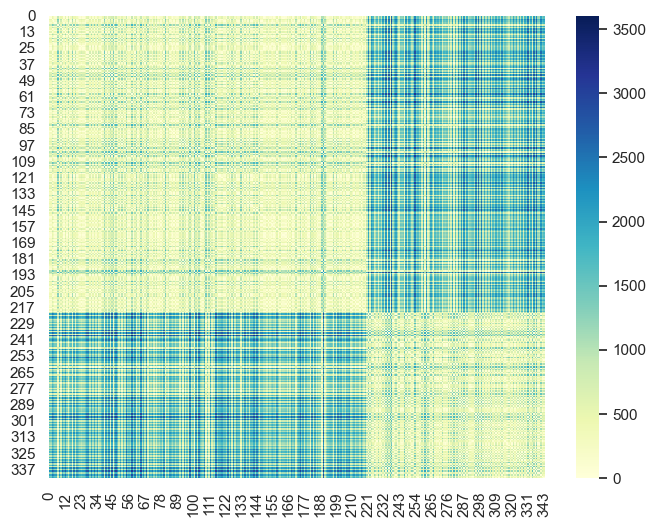

In [24]:
# Heatmap de distancias para todas las obervaciones

plt.figure(figsize=(8, 6))
df_distance = pd.DataFrame(distance_matrix, index = penguins_continuas.index, columns = penguins_continuas.index)
sns.heatmap(df_distance, annot=False, cmap="YlGnBu", fmt=".1f")
plt.show()

In [25]:
pip install fastcluster

Note: you may need to restart the kernel to use updated packages.


/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


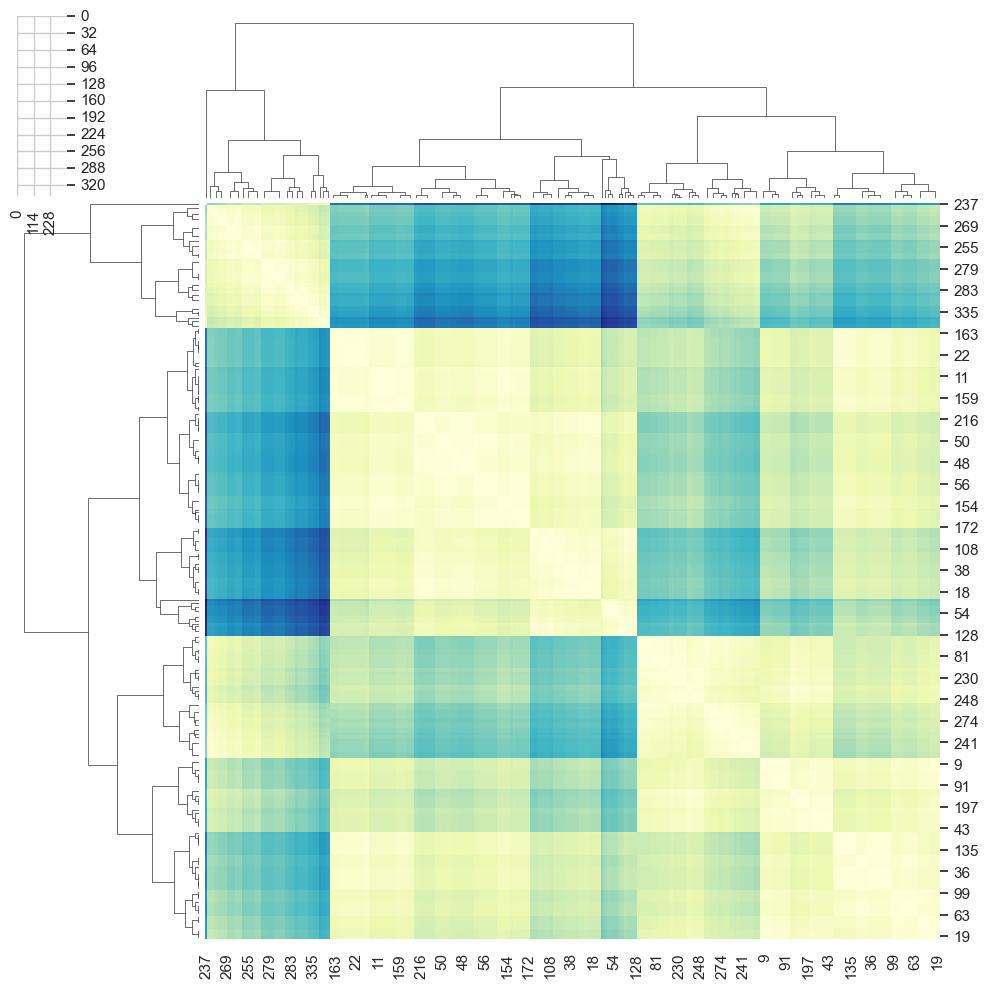

In [26]:
# Clustering jerárquico para obtener la matriz de enlaces.

linkage = sns.clustermap(df_distance, cmap="YlGnBu", fmt=".1f", annot=False, method='average').dendrogram_row.linkage
order = pd.DataFrame(linkage, columns=['cluster_1', 'cluster_2', 'distance', 'new_count']).index
reordered_data = penguins_continuas.reindex(index=order, columns=order)
sns.heatmap(reordered_data, cmap="YlGnBu", fmt=".1f", cbar=False)
plt.show()

#### Repetición del proceso con variables estandarizadas

In [27]:
# Matriz de distancias con variables estandarizadas

scaler = StandardScaler()
penguins_std = pd.DataFrame(scaler.fit_transform(penguins_continuas), columns=penguins_continuas.columns)
penguins_std_distance = distance.cdist(penguins_std, penguins_std, "euclidean")
print(penguins_std_distance[:5, :5].round(2))

[[0.   0.76 1.25 1.08 1.16]
 [0.76 0.   1.   1.28 1.66]
 [1.25 1.   0.   0.98 1.47]
 [1.08 1.28 0.98 0.   0.88]
 [1.16 1.66 1.47 0.88 0.  ]]


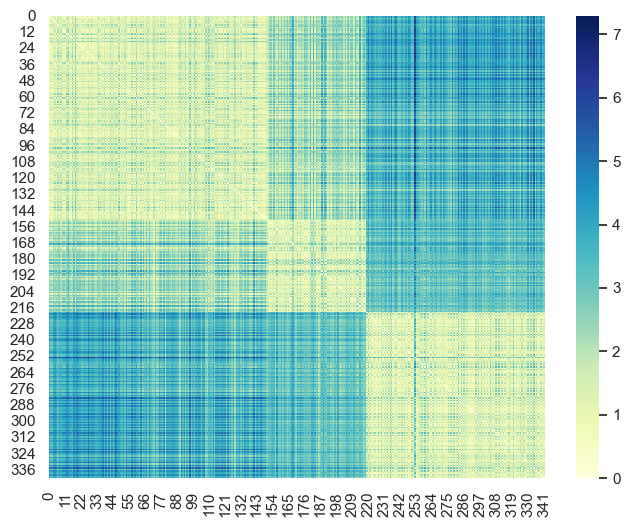

In [28]:
# Heatmap de las distancias

plt.figure(figsize=(8, 6))
penguins_std_distance_df = pd.DataFrame(penguins_std_distance, index=penguins_std.index, columns=penguins_std.index)
sns.heatmap(penguins_std_distance_df, annot=False, cmap="YlGnBu", fmt=".1f")
plt.show()

En este gráfico se pueden distinguir claramente tres colores muy diferentes, lo que sugiere que tres clústeres serían adecuados. Sin embargo, el azul más oscuro parece tener una pequeña variación hacia un tono ligeramente diferente, lo que podría indicar que en realidad hay cuatro clústeres.

/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


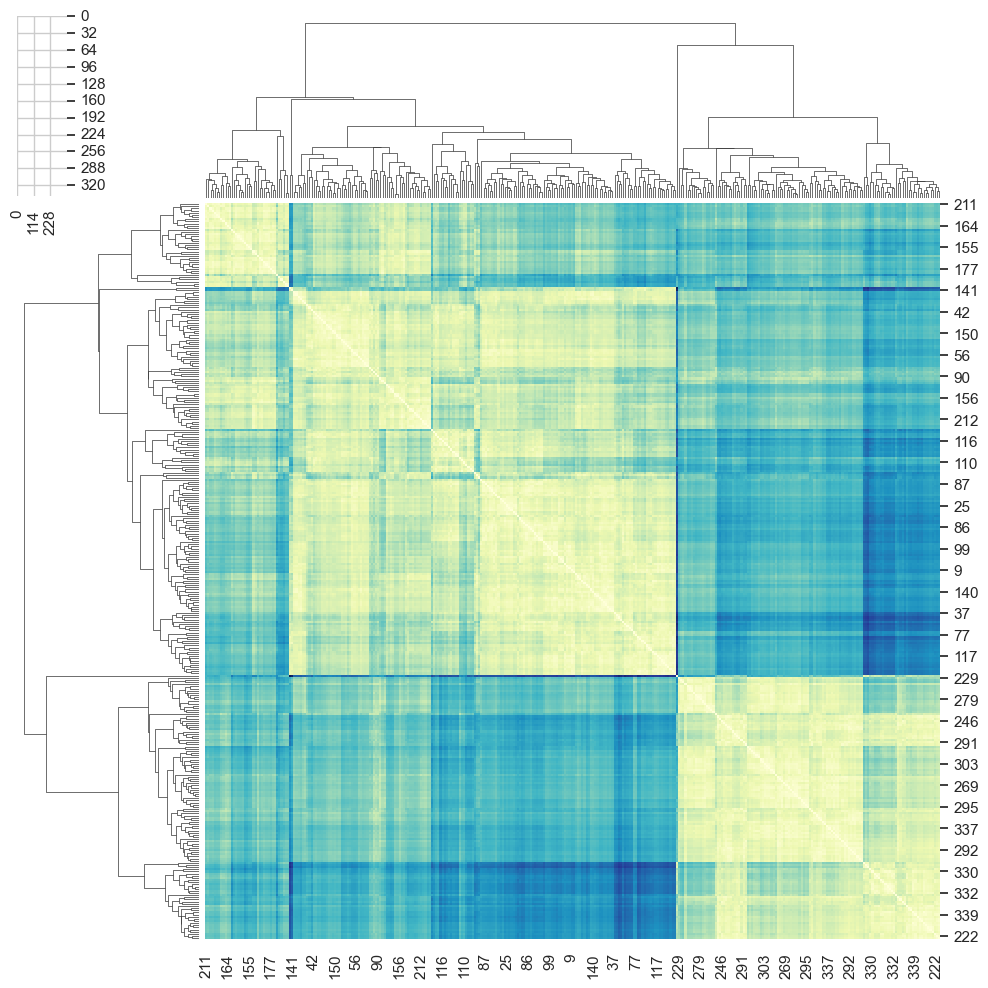

In [29]:
# Clustering jerárquico para obtener la matriz de enlaces.

linkage = sns.clustermap(penguins_std_distance, cmap="YlGnBu", fmt=".1f", annot=False, method='average').dendrogram_row.linkage
order = pd.DataFrame(linkage, columns=['cluster_1', 'cluster_2', 'distance', 'new_count']).index
reordered_data = penguins.reindex(index=order, columns=order)
sns.heatmap(reordered_data, cmap="YlGnBu", fmt=".1f", cbar=False)
plt.show()

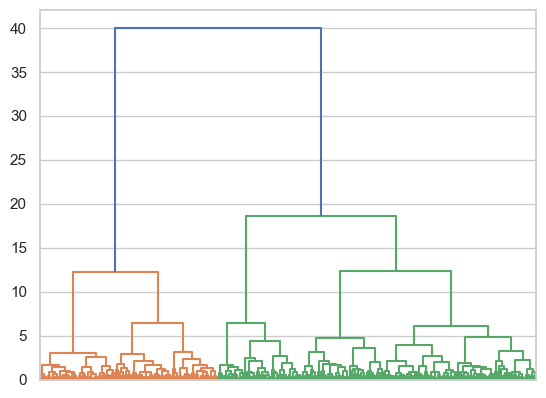

In [30]:
# Creación del dendrograma

penguins_std_distance_non_condensed = squareform(penguins_std_distance)
linkage_matrix = sch.linkage(penguins_std_distance_non_condensed, method='ward')
dendrogram = sch.dendrogram(linkage_matrix, labels=penguins_continuas.index, leaf_font_size=9, leaf_rotation=90, no_labels=True)
plt.show()

Después de analizar mis gráficas, he decidido elegir 3 clústeres, realizando una partición en el valor 15. De esta manera, obtengo tres clústeres.

In [31]:
# Asignar cada observación a uno de los 3 clústeres 

num_clusters = 3
cluster_assignments = sch.fcluster(linkage_matrix, num_clusters, criterion='maxclust')
print("Cluster Assignments:", cluster_assignments)
plt.show()

Cluster Assignments: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 2 2 2 2 2 2 3 2 3 2 2 2 2 2 2 2 2 2 2 2 3 2 3 2 2 2 2 2 2 2 3 2 3 2
 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 3 2 2 3 2 2 2 2 3 2 2 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]


In [32]:
# Agregar variable al dataframe

penguins_continuas['Cluster3'] = cluster_assignments
print(penguins_continuas["Cluster3"])

0      3
1      3
2      3
4      3
5      3
      ..
338    1
340    1
341    1
342    1
343    1
Name: Cluster3, Length: 342, dtype: int32


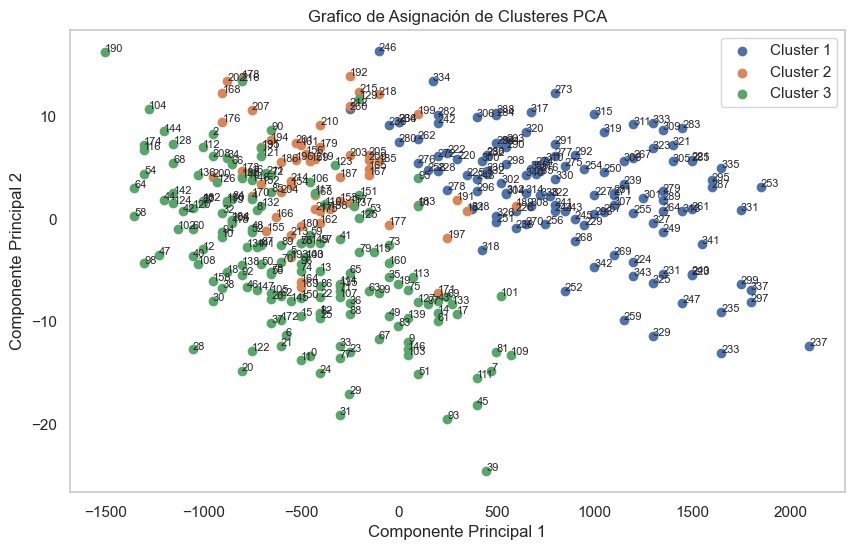

In [33]:
# Representación de los datos y su pertenencia a los clusters

pca = PCA(n_components=2)
principal_components = pca.fit_transform(penguins_continuas)

penguins_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

plt.figure(figsize=(10, 6))

for cluster in np.unique(cluster_assignments):
    plt.scatter(penguins_pca.loc[cluster_assignments == cluster, 'PC1'],
                penguins_pca.loc[cluster_assignments == cluster, 'PC2'],
                label=f'Cluster {cluster}')
    
for i, row in penguins_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(penguins_continuas.index[i]), fontsize=8)

plt.title("Grafico de Asignación de Clusteres PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.grid()
plt.show()

Parece que los tres clústeres están bien diferenciados. Aunque el segundo y el tercero están algo mezclados, claramente tienden a agruparse en una zona específica.

## 5. Agrupamiento K-Means

In [34]:
# Uso del Metodo Elbow para determinar el numero de clusteres

wcss = []

for k in range(1, 11):  # You can choose a different range of K values
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(penguins_std)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS value

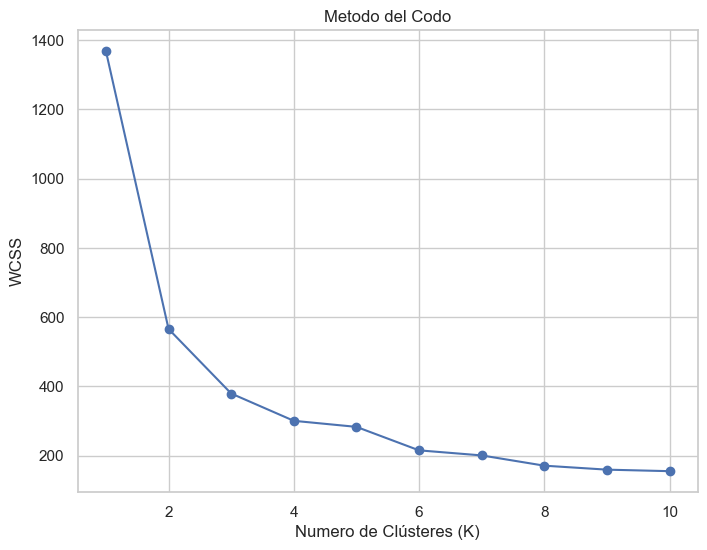

In [35]:
# Grafica del Metodo del Codo

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Metodo del Codo')
plt.xlabel('Numero de Clústeres (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

Según el método del codo, el número adecuado de clústeres podría ser 5.

In [36]:
# Aplicación del modelo KMeans para 5 clusteres

k = 5
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(penguins_std)
kmeans_cluster_labels = kmeans.labels_
print(kmeans_cluster_labels)

[2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 2 2 0 2
 0 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 0 2 0 2 2 2 2 2 2 2 0 2 0
 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 2 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 3 1
 3 4 1 1 4 1 4 1 4 1 4 1 3 1 3 1 4 4 1 1 4 1 4 1 4 1 3 4 1 1 3 4 4 1 4 1 4
 1 3 1 4 3 1 1 3 1 4 1 4 1 4 1 4 1 4 1 3 1 4 1 3 1 3 1 3 1 3 4 4 4 4 1 3 1
 3 1 3 1 3 1 3 1 3 1 4 1 3 4 3 1 3 1 3 4 4 1 3 4 3 4 3 1 4 1 3 1 4 4 3 1 3
 1 3 4 3 1 1 3 4 4]


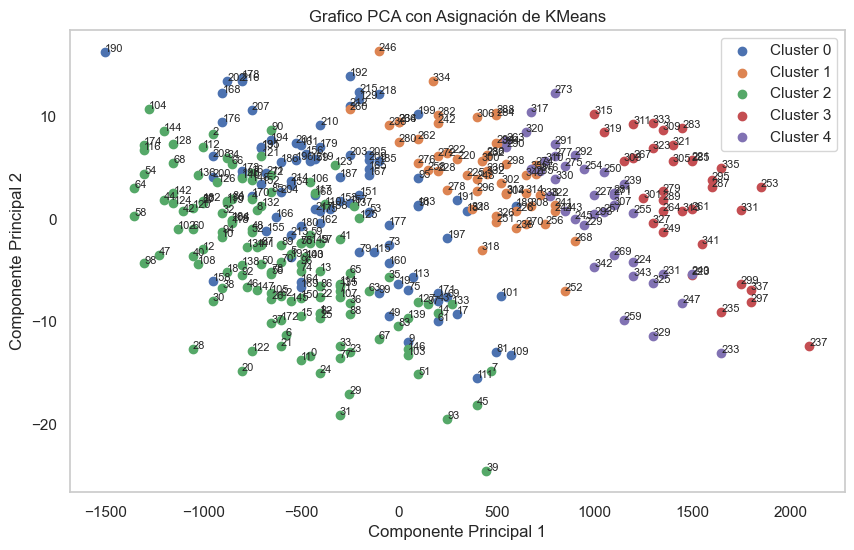

In [37]:
# Diagrama de dispersión de observaciones aplicando un color para cada cluster

plt.figure(figsize=(10, 6))
for cluster in np.unique(kmeans_cluster_labels):
    plt.scatter(penguins_pca.loc[kmeans_cluster_labels == cluster, 'PC1'],
                penguins_pca.loc[kmeans_cluster_labels == cluster, 'PC2'],
                label=f'Cluster {cluster}')
for i, row in penguins_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(penguins_continuas.index[i]), fontsize=8)

plt.title("Grafico PCA con Asignación de KMeans")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.grid()
plt.show()

Parece que cinco clústeres funcionan bien, ya que se observa una clara diferencia y agrupamiento en cada uno. Aunque los clústeres 0 y 4 están algo mezclados, aún predomina un espacio distinto para cada clúster.

#### Metodo DBSCAN

In [38]:
# Aplicación del Modelo DBSCAN

dbscan = DBSCAN(eps=0.1, min_samples=2)
dbscan.fit(penguins_std)
dbscan_labels = dbscan.labels_
print(dbscan_labels)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

In [39]:
# Obtención del número de clusteres y los parámetros correspondientes con el Metodo DBSCAN


eps_values = np.linspace(0.1, 1.0, 10)
min_samples_values = np.arange(2, 12)
num_clusters_prev = None
eps_best = None
min_samples_best = None
num_iterations = 0

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(penguins_std)
        num_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

        if num_clusters != num_clusters_prev:
            print(f"Iteración {num_iterations + 1}: eps={eps}, min_samples={min_samples}, Número de clusters={num_clusters}")
            num_clusters_prev = num_clusters
            eps_best = eps
            min_samples_best = min_samples

        num_iterations += 1
        if num_iterations >= 100:
            break
    if num_iterations >= 100:
        break

Iteración 1: eps=0.1, min_samples=2, Número de clusters=0
Iteración 11: eps=0.2, min_samples=2, Número de clusters=25
Iteración 12: eps=0.2, min_samples=3, Número de clusters=2
Iteración 13: eps=0.2, min_samples=4, Número de clusters=0
Iteración 21: eps=0.30000000000000004, min_samples=2, Número de clusters=46
Iteración 22: eps=0.30000000000000004, min_samples=3, Número de clusters=21
Iteración 23: eps=0.30000000000000004, min_samples=4, Número de clusters=12
Iteración 24: eps=0.30000000000000004, min_samples=5, Número de clusters=4
Iteración 25: eps=0.30000000000000004, min_samples=6, Número de clusters=0
Iteración 31: eps=0.4, min_samples=2, Número de clusters=20
Iteración 32: eps=0.4, min_samples=3, Número de clusters=9
Iteración 34: eps=0.4, min_samples=5, Número de clusters=10
Iteración 35: eps=0.4, min_samples=6, Número de clusters=7
Iteración 36: eps=0.4, min_samples=7, Número de clusters=6
Iteración 37: eps=0.4, min_samples=8, Número de clusters=5
Iteración 38: eps=0.4, min_sam

Para valores bajos de eps (0.1-0.3), el número de clústeres varía considerablemente y en algunos casos es 0, lo que sugiere que los puntos no están suficientemente agrupados. A partir de eps = 0.4, los números de clústeres se vuelven más estables. Podría elegir 3 o 4 clústeres; como ya trabajé con 3, optaré por 4 para poder compararlo con el K-means y obtener un valor razonablemente bueno.

In [40]:
# Crear el modelo DBSCAN con parametros obtenidos

dbscan = DBSCAN(eps=0.6, min_samples=10)
dbscan.fit(penguins_std)
dbscan_labels = dbscan.labels_
print(dbscan_labels)

[ 0  0  0  0 -1  0 -1  0 -1  0  0  0 -1 -1  0  0 -1  0 -1  0  0  0  0  0
  0  0  0 -1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0  0  0 -1  0
 -1  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0
 -1  0  0  0  0  0  0  0 -1  0  0  0 -1  0  0  0  0  0  0  0  0  0 -1  0
  0 -1  0  0 -1  0  0 -1  0 -1  0  0 -1 -1 -1  0  0 -1  0  0 -1  0  0  0
  0 -1  0  0  0  0  0  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0 -1  0  0
  0  0  0  0  0  0  0  1  2  2  1  2  0 -1  2  0  2  1  2  1  2  1  2  2
 -1  1 -1  0  1 -1  2  1  2  2  2  1 -1  0 -1  0  2  2  1  1 -1 -1 -1 -1
  1  2  1  2  2  2 -1 -1  2 -1  2  1  2  0  2  1  2  2 -1  2  1  1 -1 -1
  1  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3 -1  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3 -1  3  3  3 -1  3 -1  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3 -1  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3 -1  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3 -1  3  3  3  3  3  3  3  3

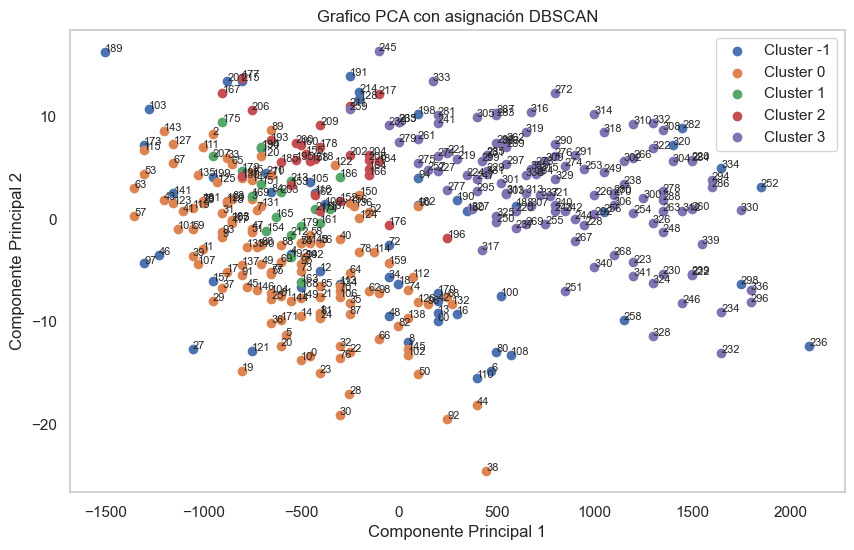

In [41]:
# Grafico de Dispersión con Color por cada Cluster

plt.figure(figsize=(10, 6))

for cluster in np.unique(dbscan_labels):
    plt.scatter(penguins_pca.loc[dbscan_labels == cluster, 'PC1'],
                penguins_pca.loc[dbscan_labels == cluster, 'PC2'],
                label=f'Cluster {cluster}')

for i, row in penguins_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(penguins.index[i]), fontsize=8)

plt.title("Grafico PCA con asignación DBSCAN")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.grid()
plt.show()

Esta solución no tiene mucho sentido, ya que algunos clústeres, como el -1 y el 1, no parecen estar bien agrupados. Esto destaca una limitación importante del método, y explica por qué en este caso sería más robusto y ofrecería una solución mucho más satisfactoria y razonable.

## 6. Validación del Agrupamiento

### Metodo de Siluetas

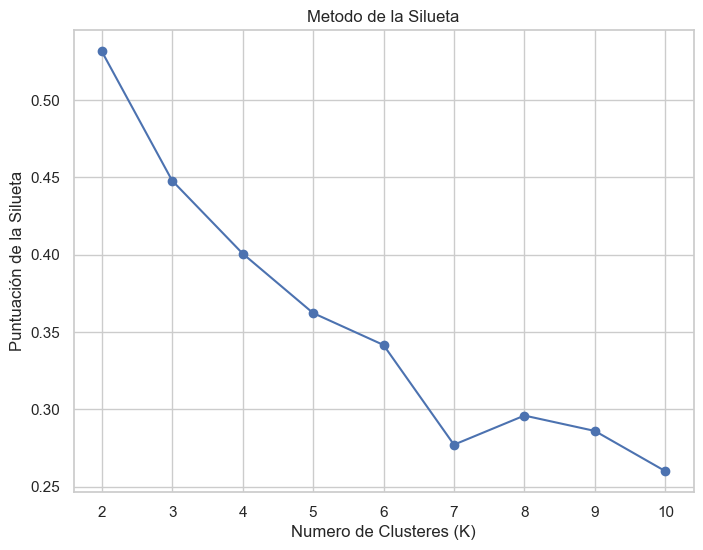

In [42]:
# Representación Grafica del Metodo de la Silueta

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(penguins_std)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(penguins_std, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Metodo de la Silueta')
plt.xlabel('Numero de Clusteres (K)')
plt.ylabel('Puntuación de la Silueta')
plt.grid(True)
plt.show()

Segun la grafica, el numero optimo de clusteres es 6, por tanto, usaremos el metodo K-means con 6 clústeres para obtener las etiquetas de los clústeres para cada punto de datos.

In [43]:
# KMeans con 6 clusteres

kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(penguins_std)
labels = kmeans.labels_

In [44]:
# Calculo de  las puntuaciones de silueta para cada clúster.

silhouette_values = silhouette_samples(penguins_std, labels)
silhouette_values

array([ 0.15887399,  0.32227658,  0.2851751 ,  0.07979895,  0.29670607,
        0.40399818,  0.47570629,  0.35339304,  0.4865162 ,  0.56000063,
        0.43276541,  0.43050698,  0.34185115,  0.32581251,  0.4153146 ,
        0.02466695,  0.41320735,  0.42121224,  0.12673366,  0.3701447 ,
        0.29205092, -0.01100625,  0.15496256,  0.37530477,  0.13010228,
        0.20734559,  0.42531481,  0.34761907,  0.0522533 ,  0.47796098,
        0.26150251,  0.46700955,  0.13644937,  0.45794234,  0.4498195 ,
        0.38206807,  0.16408801,  0.2648272 ,  0.34497885,  0.50754833,
        0.26018121,  0.44660577,  0.31745314,  0.55294106,  0.40596616,
        0.15641121,  0.37343551,  0.4614713 ,  0.40663555,  0.43669824,
        0.38316138,  0.44569809,  0.43984882,  0.45927124,  0.11191723,
        0.46414056,  0.251935  ,  0.51277674,  0.13081826,  0.55235716,
        0.45694696,  0.49823451,  0.2609309 ,  0.52964538,  0.1612084 ,
        0.43521344,  0.37843973,  0.52375411,  0.48494287,  0.19

/var/folders/lm/vmzl45zd5n35pv4pvhxh_9zm0000gn/T/ipykernel_24165/182365061.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap("Spectral")(float(i) / 6)


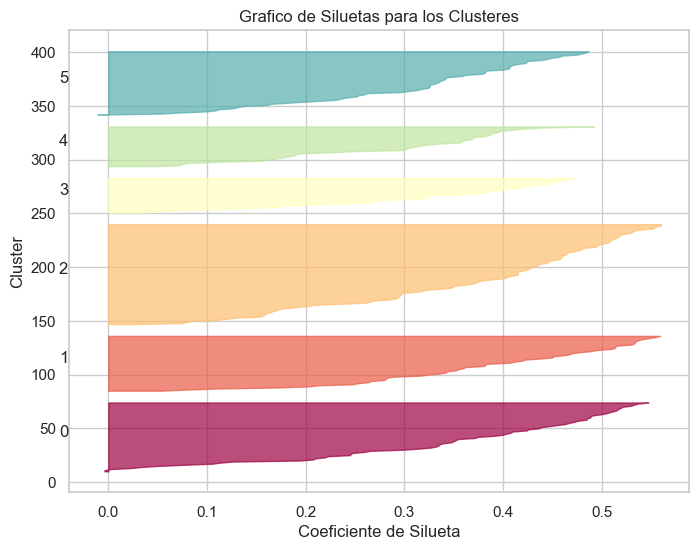

In [45]:
# Grafico de las Siluetas de cada cluster

plt.figure(figsize=(8, 6))
y_lower = 10

for i in range(6):
    ith_cluster_silhouette_values = silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = plt.cm.get_cmap("Spectral")(float(i) / 6)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.title("Grafico de Siluetas para los Clusteres")
plt.xlabel("Coeficiente de Silueta")
plt.ylabel("Cluster")
plt.grid(True)
plt.show()

La mayoría de los coeficientes están por encima de 0, lo que indica que el agrupamiento tiene una separación razonablemente buena. Aunque los clústeres 5 y 0 presentan algunas observaciones por debajo de 0, esto no parece ser muy relevante. Algunos clústeres muestran una mayor dispersión, lo que sugiere que podrían contener puntos con menor cohesión interna. Los clústeres 4 (verde) y 3 (amarillo) son los que más se acercan al centroide.

## 6. Jerarquico versus K-Means

Al comparar la agrupación jerárquica y K-means, nos damos cuenta de que en realidad son muy similares. En el dendrograma, al hacer un corte en el valor 10, obtenemos 5 clústeres, lo cual tiene sentido, ya que todos se encuentran en el mismo nivel de distancia antes de saltar a la siguiente división. Esto coincide con lo que sugiere el método de K-means, que también indica que 5 clústeres son los óptimos para este conjunto de datos.

In [46]:
# Etiquetas para el Dataframe representando cada cluster

penguins_std['label'] = labels
penguins_std_sort = penguins_std.sort_values(by="label")
penguins_std_sort['label']

170    0
185    0
186    0
187    0
188    0
      ..
78     5
80     5
82     5
58     5
13     5
Name: label, Length: 342, dtype: int32

In [47]:
# Calculo de los centroides estandarizados·

cluster_centroids = penguins_std_sort.groupby('label').mean()
cluster_centroids.round(2)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
label,,,,
0,0.97,0.70,-0.29,-0.53
1,0.24,-1.54,0.79,0.52
2,-1.12,0.24,-0.99,-1.00
3,1.29,-0.56,1.73,1.83
4,0.68,-0.96,1.16,1.24
5,-0.65,1.12,-0.51,-0.09


In [48]:
# Calculo de los centroides sin estandarizar

penguins_continuas['label'] = labels
penguins_sort = penguins_continuas.sort_values(by="label")
cluster_centroids_orig = penguins_sort.groupby('label').mean()
cluster_centroids_orig.round(2)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,Cluster3
label,,,,,
0,49.22,18.54,196.83,3778.46,2.12
1,45.22,14.11,212.08,4614.42,1.00
2,37.83,17.63,187.05,3398.14,3.00
3,50.95,16.04,225.21,5663.64,1.00
4,47.64,15.26,217.21,5197.37,1.00
5,40.39,19.35,193.70,4127.08,3.00


## 7. Interpretación de los Grupos

In [49]:
# DataFrame de mis datos estandarizados junto con las componentes, los cluster y las especies.

# 1. Componentes
pca = PCA(n_components=2)
fit = pca.fit(penguins_std)
resultados_pca = pd.DataFrame(fit.transform(penguins_std),
                             columns=['Componente 1', 'Componente 2'],
                             index=penguins_std.index)
penguins_z_cp = pd.concat([penguins_std, resultados_pca], axis=1)
if 'label' in penguins_z_cp.columns:
    penguins_z_cp = penguins_z_cp.drop(columns=['label'])

# 2. Clusteres
k = 5
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(penguins_std)
kmeans_cluster_labels = kmeans.labels_
penguins_z_cp['Cluster'] = kmeans_cluster_labels

# 3. Especies
penguins_z_cp['Species'] = penguins['species']

display(penguins_z_cp)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,Componente 1,Componente 2,Cluster,Species
0,-0.884499,0.785449,-1.418347,-0.564142,-0.412482,-1.812500,2,Adelie
1,-0.811126,0.126188,-1.062250,-0.501703,-0.413515,-1.272084,2,Adelie
2,-0.664380,0.430462,-0.421277,-1.188532,-0.503155,-1.324426,2,Adelie
3,-1.324737,1.089724,-0.563715,-0.938776,-0.337461,-1.856976,2,Adelie
4,-0.847812,1.748985,-0.777373,-0.689020,2.557149,-2.181268,4,Adelie
...,...,...,...,...,...,...,...,...
337,0.601305,-1.750171,0.931890,0.903175,-1.145228,2.133114,3,Gentoo
338,0.527932,-1.445897,1.003109,0.809516,-1.130780,1.964745,3,Gentoo
339,1.188289,-0.735923,1.501644,1.933419,1.056408,2.666465,1,Gentoo
340,0.234440,-1.192335,0.789451,1.246590,1.875089,1.541196,1,Gentoo


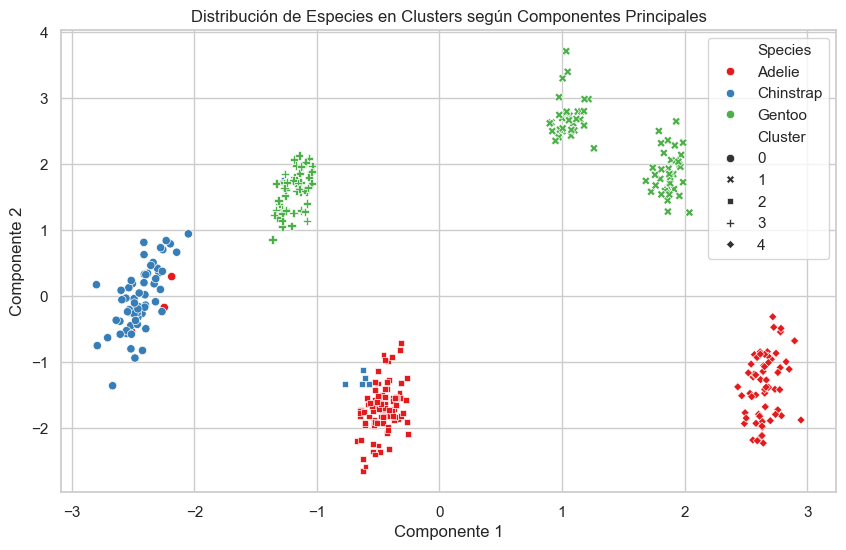

In [50]:
# Visualización de la distribución de especies en los clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Componente 1', y='Componente 2', hue='Species', style='Cluster', data=penguins_z_cp, palette='Set1')
plt.title('Distribución de Especies en Clusters según Componentes Principales')
plt.show()

In [51]:
# Tabla de contingencia para ver la distribución de especies en los clusters

contingency_table = pd.crosstab(penguins_z_cp['Species'], penguins_z_cp['Cluster'])
print(contingency_table)

Cluster     0   1   2   3   4
Species                      
Adelie      3   0  89   0  60
Chinstrap  62   0   5   1   0
Gentoo      0  71   0  51   0


Los clústeres 0 y 2 muestran una mezcla de pingüinos Adelie y Chinstrap (aunque son pocas observaciones las que se mezclan), lo que podría interpretarse como una indicación de que estas dos especies tienen características físicas similares en las dimensiones consideradas. Esto podría deberse a que ambas especies comparten hábitats y comportamientos similares.

En cuanto a los clústeres exclusivos, el clúster 4 sugiere que existe un subgrupo de pingüinos Adelie con características físicas distintivas que los diferencian de otros Adelie y de los Chinstrap. Por otro lado, los clústeres 1 y 3 parecen tener características físicas que los diferencian claramente de todas las demás especies, lo que indica que podrían estar representando exclusivamente a los pingüinos Gentoo.

## 9. Conclusión del Analisis

En conclusión, el análisis del conjunto de datos penguins ha permitido identificar patrones en las características físicas de diferentes especies de pingüinos mediante técnicas de reducción de dimensionalidad y agrupamiento. Utilizando el Análisis de Componentes Principales (ACP), se observó que la longitud del pico, la masa corporal y la longitud de la aleta son las variables clave que explican más del 80% de la variabilidad. El agrupamiento realizado mediante K-means y validado con el método jerárquico sugiere que cinco o seis clústeres son adecuados. Los clústeres 0 y 2 indican similitudes físicas entre Adelie y Chinstrap, mientras que los clústeres exclusivos (4 para Adelie y 1 y 3 para Gentoo) destacan subgrupos con características distintivas. Estos resultados ayudan a comprender mejor las diferencias y similitudes entre las especies de pingüinos.